In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

import acquire
import prep

## To-Do:
- Use model on test - *Done*
- Compare chosen model to baseline - *Done*
- Visualizations of drivers of property value - *Done*
- Add docstrings to modeling.py (and consider renaming to evaluate.py)
- Data Dictionary
- Clean readme.md with final notebook information
    - Add "Repeat My Work" instructions
- Make slides
- Practice presentation

Model notes:
- LA county has information on has_pool and 17,000+ results, could build model specifically on it and have has_pool delineation later with more information. Might need to only do this for LA county (overfit for LA county if try to include other county)

Presentation notes:
- UseCode (propertycountylandusecode) would give valuable insights if we had access to tax assessors' code definitions


# #1. Acquire the correct data subset from the 'zillow' dataset

## Import

In [2]:
# from env import host, username, password
# def get_db_url(db_name, username=username, hostname=host, password=password):
#     return f'mysql+pymysql://{username}:{password}@{hostname}/{db_name}'

## Acquire

In [3]:
# url = get_db_url(db_name='zillow')
# query = """
#             SELECT parcelid as ID,
#                     transactiondate as DateSold,
#                     taxvaluedollarcnt as Worth,
#                     taxamount as Taxes,
#                     roomcnt as Rooms,
#                     bathroomcnt as Baths,
#                     bedroomcnt as Beds,
#                     garagecarcnt as GarageCarCount,
#                     numberofstories as Stories,
#                     lotsizesquarefeet as LotSize,
#                     garagetotalsqft as GarageSize,
#                     calculatedfinishedsquarefeet as FinishedSize,
#                     yearbuilt as YearBuilt,
#                     fips as LocalityCode,
#                     regionidcounty as County,
#                     regionidzip as Zipcode,
#                     propertycountylandusecode as UseCode
#             FROM properties_2017
#             JOIN predictions_2017 USING(parcelid)
#             WHERE propertylandusetypeid = 261 AND 
#                   transactiondate BETWEEN '2017-05-01' AND '2017-08-31'
#         """

In [4]:
# df = pd.read_sql(query, url)
# df.head(3)

## Store to .csv

In [5]:
# if not os.path.isfile('zillow.csv'):
#     df.to_csv('zillow.csv')

* **ACQUIRE.py**: 
    * Add get_db_url - *Done*
    * Add acquire-store function - *Done*

In [6]:
df = acquire.acquire_zillow()
df.head(3)

,ID,LocalityCode,DateSold,Worth,Taxes,Rooms,Baths,Beds,GarageCarCount,Stories,LotSize,GarageSize,FinishedSize,YearBuilt,County,Zipcode,UseCode
0,11721753,6037.0,2017-07-21,205123.0,2627.48,0.0,2.0,3.0,NaN,NaN,5672.0,NaN,1316.0,1923.0,3101.0,95997.0,0100
1,11289917,6037.0,2017-06-23,136104.0,2319.90,0.0,2.0,3.0,NaN,NaN,8284.0,NaN,1458.0,1970.0,3101.0,97318.0,0101
2,11705026,6037.0,2017-06-30,35606.0,543.69,0.0,1.0,2.0,NaN,NaN,6707.0,NaN,1421.0,1911.0,3101.0,96018.0,0100


* **Present**:
    * Acquisition steps and data subsecting

# #2. Create a distribution for residence locality (state, county) against tax rate

* Notebook: Explore data for locality information
    * **Deliverable**: List of states and counties where properties are located
        * 6037: Los Angeles, CA
        * 6059: Orange, CA
        * 6111: Ventura, CA

## Investigate locality information

In [7]:
# df[['County','LocalityCode']].value_counts()

These three groups might be correct, let's investigate the Zipcode column...

In [8]:
# Create array of unique zip codes, converted to five character str
# zips = pd.DataFrame(df['Zipcode'].value_counts().keys().astype('int').astype('str').tolist())
# Subsect zip codes to first three digits
# zips[0] = zips[0].str[:3]
# Show unique first-three-digits
# zips.value_counts()

- 961: Reno, NV (West)
- 960: Redding, CA
- 962: Armed Forces - Korea
- 970: Portland, OR (Vicinity)
- 963: Armed Forces - Japan
- 969: Barrigda, Guam
- 964: Armed Forces - Phillipines
- 959: Marysville, CA
- 965: Armed Forces - Pacific
- 973: Salem, OR
- 971: Portland, OR (West)
- 399: Atlanta, GA (IRS)
- 972: Portland, OR (Main)

This doesn't seem quite right. The FIPS code might be the right one.

In [9]:
# Checking aliased fips column
df['LocalityCode'].unique()

array([6037., 6059., 6111.])

- 6037: Los Angeles, CA
- 6059: Orange, CA
- 6111: Ventura, CA

This seems correct, these three are all counties in California. We're going with that.

## Calculate tax rate for each property

In [10]:
df['TaxRate'] = round((df['Taxes'] / df['Worth']) * 100, 2)
df[['Worth','Taxes','TaxRate']].head(3)

,Worth,Taxes,TaxRate
0,205123.0,2627.48,1.28
1,136104.0,2319.90,1.70
2,35606.0,543.69,1.53


## Create distribution of tax rates for each county
* **Deliverable**: This distribution

In [11]:
# sns.histplot(df, x='TaxRate', hue='LocalityCode')

That doesn't look right. Let's see what went wrong...

In [12]:
# df.TaxRate.sort_values(ascending=False).head(20)

Ok, let's drop all values over 10% and see what happens...

In [13]:
# sns.histplot(df[df.TaxRate < 10], x='TaxRate', hue='LocalityCode', palette='bright')

So it seems most values are between 1% and 2%, which checks. So let's see what value is poking out...

In [14]:
# df.TaxRate.value_counts().head(10)

The 2500-count value isn't appearing, weird. Let's zoom way in...

In [15]:
# mask = (df.TaxRate > 1.1) & (df.TaxRate < 1.5)
# sns.histplot(df[mask], x='TaxRate', hue='LocalityCode', palette='bright')

So it seems two values were grouped into one bar. Let's widen the view a bit to capture the distribution without combining two tax rates.

In [16]:
# mask = (df.TaxRate > 0.9) & (df.TaxRate < 1.7)
# sns.histplot(df[mask], x='TaxRate', hue='LocalityCode', palette='bright', kde=True)

In [17]:
# def remove_outliers(df, k, col_list):
#     for col in col_list:
#         q1, q3 = df[col].quantile([.25, .75])  # get quartiles
#         iqr = q3 - q1   # calculate interquartile range
#         upper_bound = q3 + k * iqr   # get upper bound
#         lower_bound = q1 - k * iqr   # get lower bound
#         # return dataframe without outliers
#         df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
#     return df

In [18]:
# new = prep.remove_outliers(df, 1.5, ['TaxRate','Worth','Taxes'])
# sns.histplot(new, x='TaxRate', hue='LocalityCode', palette='bright', kde=True)

Cool. So, clean up this distribution and put it in the presentation. Some things you should note:
- Each locality's highest rate
- General shape of distributions
- Any odd phenomenon, like the seemingly-random peaks through the skew
    * This is likely two values grouped into one

* **Present**: 
    * All localities for dataset's residences
    * Each locality's tax rate range
    * Each peak in the tax rate distributions

# #3. Conduct hypothesis testing and check univariate distributions

### Univariate Distributions

* Notebook: Initial exploration
    * Use square-footage, bedroom-count, bathroom-count, and tax-value for initial exploration
    * *After MVP*: Run initial exploration on new features

In [19]:
# df.columns

In [20]:
# initial = df[['Worth','FinishedSize','Beds','Baths']]
# print(initial.info())
# initial = initial.dropna()
# initial = initial.drop_duplicates()
# initial.info()

In [21]:
# def initial_plots(df):
#     for col in df.columns:
#         # Raw plots
#         sns.histplot(df, x=col)
#         plt.title(col)
#         plt.show()
        
#         # Interquartile Rule
#         q1, q3 = df[col].quantile([.25, .75])  # get quartiles
#         k = 1.5
#         iqr = q3 - q1   # calculate interquartile range
#         upper_bound = q3 + k * iqr   # get upper bound
#         lower_bound = q1 - k * iqr   # get lower bound
#         temp = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
#         sns.histplot(temp, x=col)
#         plt.title(col + '_no_outliers')
#         plt.show()

In [22]:
# df['Worth'].dtype == 'float64'

In [23]:
# prep.initial_plots(initial)

In [24]:
# prep.initial_plots(df)

### Hypothesis Testing

* Notebook: Hypothesis testing
    * Create initial hypotheses for MVP features, push to readme
    * Run statistical tests
        * At least two statistical tests along with visualizations documenting hypotheses and takeaways
    * Convey results to readme and Jupyter notebook
    * *After MVP*: Create hypotheses for new features 
    * *After MVP*: Push new features through hypothesis testing to check viability
    * *After MVP*: Convey results to readme and Jupyter notebook

**Initial Hypotheses** (two for MVP):
- There is a linear relationship between a home's value and the number of bedrooms it has.
- The value of a home with two bedrooms is not statistically different from a home with two bathrooms.

**Confidence Interval = 95%**

In [25]:
def significant(alpha, truth, p):
    if p < alpha and truth:
        print("Reject the null hypothesis")
    else:
        print("Accept the null hypothesis")

In [26]:
# Spearman test to determine correlation between Worth and Beds
alpha = .05
corr, p = stats.spearmanr(df.dropna().Worth, df.dropna().Beds)
truth = True
significant(alpha, truth, p)

Reject the null hypothesis


In [27]:
# Mannwhitney test to determine statistical difference between 
# Worth of homes with 2 Beds and Worth of homes with 2 Baths
t, p = stats.mannwhitneyu(df[df.Beds == 2].dropna().Worth, df[df.Baths == 2].dropna().Worth) 
if p > alpha: # Note: hypothesis is that there *isn't* a statistical difference
    print("Reject the null hypothesis")
else:
    print("Accept the null hypothesis")

Accept the null hypothesis


* **PREP.py**: 
    * Add initial-plots function to loop through and plot features - *Done*
* **Present**: 
    * First four distributions
    * *After MVP*: Any additional distributions included/excluded
    * Initial hypotheses
    * Statistical tests
    * Results

# #4. Prepare using Minimum-Viable-Product (MVP) specification restriction

### 1. Drop all columns except square-footage, bedroom-count, bathroom-count, tax-value

In [28]:
# df = df[['Worth','FinishedSize','Beds','Baths']]
# df.head(3)

### 2. Drop all nulls and duplicates in above columns

In [29]:
# print("Before:", df.shape)
# df = df.dropna().drop_duplicates()
# print("After:", df.shape)

In [30]:
# print("Before:", df.shape)
# df = df
# print("After:", df.shape)

### 3. Check for outliers using box-and-whisker plot

In [31]:
# for col in df.columns:
#     sns.boxplot(data=df[col])
#     plt.show()

### 4. Eliminate outliers if needed using Inter-Quartile Rule

In [32]:
# df = remove_outliers(df, k=1.5, col_list=['Worth','FinishedSize','Beds','Baths'])
# df.head(3)

### 5. Rename columns to something more readable
- Accomplished in SQL query

### 6. Split data into train, validate, and test

In [33]:
# train_validate, test = train_test_split(df, test_size=0.2, random_state=123)
# train, validate = train_test_split(train_validate, test_size=0.25, random_state=123)
# train.shape, validate.shape, test.shape

### 7. Isolate target variable 'tax-value' into y_train from X_train
Do the same for X_validate and X_test

In [34]:
# X_train, y_train = train.drop(columns='Worth'), train.Worth
# X_validate, y_validate = validate.drop(columns='Worth'), validate.Worth
# X_test, y_test = test.drop(columns='Worth'), test.Worth

### 8. Scale data
* Create and fit scaler using X_train
* Create X_train_exp using scaler transform of X_train while retaining original values
* Scale X_train, drop unscaled columns
* Scale X_validate, drop unscaled columns
* Scale X_test, drop unscaled columns

In [35]:
# scaler = StandardScaler().fit(X_train)

In [36]:
# X_train_exp = X_train.copy()
# col_list = []
# for col in X_train.columns:
#     col_list.append(col + "_scaled")
# X_train_exp[col_list] = scaler.transform(X_train)
# X_train_exp.head(3)

In [37]:
# X_train = scaler.transform(X_train)
# X_validate = scaler.transform(X_validate)
# X_test = scaler.transform(X_test)

* *After MVP*: Run through above steps as needed with any additional features
* **PREP.py**: 
    * Add plot-data function to make various plots for a dataframe when called - *Done*
    * Add clean-data function to limit dataset features, drop nulls, eliminate outliers, rename columns - *Done*
        * *After MPV*: Revise clean-data with new features
    * Add split-data function for train/validate/test *and* target isolation - *Done*
    * Add scale-data function - *Done*
    * Add wrangle-data function to run acquire-store, clean-data, split-data, and scale-data functions, then return all dataframes - *Done*
* **Present**:
    * Overview of wrangling, mentioning feature limitation to MVP, additional features, nulls, outliers, feature renaming, split, target isolation, scaler creation, scaler application, returned dataframes

## Check to see if prep.py is working as intended

In [38]:
df, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = prep.wrangle_zillow_MVP()
X_train_exp.head(3)

,FinishedSize,Beds,Baths,FinishedSize_scaled,Beds_scaled,Baths_scaled
12185,2890.0,5.0,4.0,1.897476,2.254989,2.574043
17845,1352.0,3.0,2.0,-0.598498,-0.278078,-0.167565
28109,1516.0,4.0,2.0,-0.332348,0.988456,-0.167565


# #5. Create models for MVP restriction

### 1. Cast y_train and y_validate as dataframes

In [39]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.shape, y_validate.shape

((14848, 1), (4950, 1))

### 2. Create model-performance function
* Takes in actuals_series, predictions_series, 'model_name', df_to_append_to
* Calculates RMSE
* Calculates r^2 score
* Appends dataframe with new row for model_name, RMSE_validate, r^2_score
* Returns dataframe

In [40]:
def model_performance(train_actuals, val_actuals, train_preds, val_preds, model_name, running_df):
    rmse_train = mean_squared_error(train_actuals, train_preds) ** 0.5
    rmse_validate = mean_squared_error(val_actuals, val_preds) ** 0.5
    r2_train = r2_score(train_actuals, train_preds)
    r2_validate = r2_score(val_actuals, val_preds)
    running_df = running_df.append({'Model':model_name, 
                                   'Train_RMSE': rmse_train,
                                   'Validate_RMSE': rmse_validate,
                                   'Train_r2': r2_train,
                                   'Validate_r2': r2_validate}, ignore_index=True)
    return running_df

### 3. Create plot-residuals function

In [41]:
def plot_residuals(X_train_exp_col, y_train_residuals):
    sns.scatterplot(x=X_train_exp_col, y=y_train_residuals)
    plt.axhline(0, ls = ':')
    plt.ylabel('Residuals')
    plt.show()

### 4. Create baseline model
* Calculate mean and median of target (tax-value)
* Assign mean and median to columns in y_train and y_validate
* Calculate RMSE for both train and validate
    * mean_squared_error(actuals, baseline) ** 0.5
* Keep the lower-error baseline (of mean and median)
* Calculate residuals
* Call plot-residuals

In [42]:
y_train['mean_bl'] = y_train['Worth'].mean()
y_train['median_bl'] = y_train['Worth'].median()
y_validate['mean_bl'] = y_validate['Worth'].mean()
y_validate['median_bl'] = y_validate['Worth'].median()
y_train.head(3)

,Worth,mean_bl,median_bl
12185,683726.0,388435.613618,346509.0
17845,418993.0,388435.613618,346509.0
28109,348477.0,388435.613618,346509.0


In [43]:
running_df = pd.DataFrame(columns=['Model','Train_RMSE','Validate_RMSE','Train_r2','Validate_r2'])
running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2


In [44]:
running_df = model_performance(y_train.Worth, y_validate.Worth, y_train.mean_bl, y_validate.mean_bl, 'mean_baseline', running_df)
running_df = model_performance(y_train.Worth, y_validate.Worth, y_train.median_bl, y_validate.median_bl, 'median_baseline', running_df)
running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_baseline,260807.509266,265580.600849,0.000000,0.000000
1,median_baseline,264156.010378,268905.009083,-0.025843,-0.025192


In [45]:
y_train['baseline_residual'] = y_train['Worth'] - y_train['mean_bl']
X_train_exp['log_FinishedSize'] = X_train_exp['FinishedSize'].apply(lambda x: math.log(x))

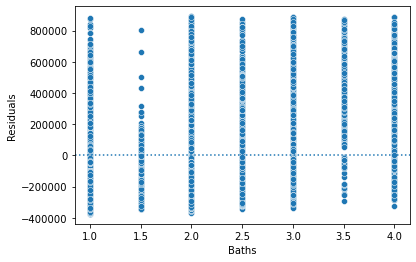

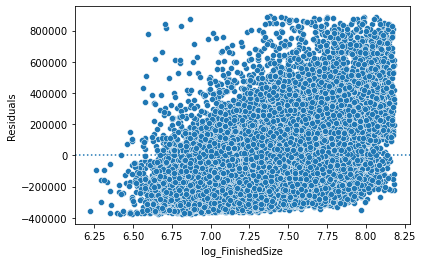

In [46]:
plot_residuals(X_train_exp.Baths, y_train.baseline_residual)
plot_residuals(X_train_exp.log_FinishedSize, y_train.baseline_residual)

### 5. Create models for different regression algorithms
* Loop through one algorithm's hyperparameters, save to list - *Will do after MVP*
* Loop through next algorithm, and next... using same - *Will do after MVP*

In [47]:
lm = LinearRegression(normalize=True)

In [48]:
lm.fit(X_train, y_train.Worth)

LinearRegression(normalize=True)

In [49]:
y_train['lm_preds'] = lm.predict(X_train)
y_validate['lm_preds'] = lm.predict(X_validate)
y_train.head(3)

,Worth,mean_bl,median_bl,baseline_residual,lm_preds
12185,683726.0,388435.613618,346509.0,295290.386382,606862.517115
17845,418993.0,388435.613618,346509.0,30557.386382,320908.446774
28109,348477.0,388435.613618,346509.0,-39958.613618,309158.179635


In [50]:
running_df = model_performance(train_actuals=y_train.Worth,
                                val_actuals=y_validate.Worth,
                                train_preds=y_train.lm_preds,
                                val_preds=y_validate.lm_preds,
                                model_name='ols',
                                running_df=running_df)

running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_baseline,260807.509266,265580.600849,0.000000,0.000000
1,median_baseline,264156.010378,268905.009083,-0.025843,-0.025192
2,ols,229218.069507,233224.734268,0.227573,0.228819


<AxesSubplot:xlabel='Baths', ylabel='lm_preds'>

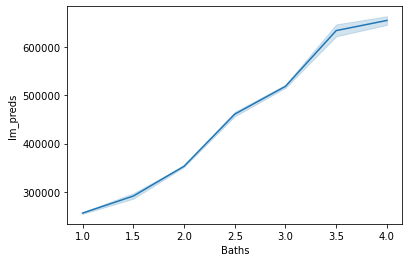

In [51]:
sns.lineplot(x=X_train_exp.Baths, y=y_train.lm_preds)

In [52]:
lars = LassoLars(alpha=1)
lars.fit(X_train, y_train.Worth)
y_train['lars_1_preds'] = lars.predict(X_train)
y_validate['lars_1_preds'] = lars.predict(X_validate)
y_train.head(3)

,Worth,mean_bl,median_bl,baseline_residual,lm_preds,lars_1_preds
12185,683726.0,388435.613618,346509.0,295290.386382,606862.517115,606827.504947
17845,418993.0,388435.613618,346509.0,30557.386382,320908.446774,320960.255131
28109,348477.0,388435.613618,346509.0,-39958.613618,309158.179635,309576.317371


In [53]:
running_df = model_performance(train_actuals=y_train.Worth,
                                val_actuals=y_validate.Worth,
                                train_preds=y_train.lars_1_preds,
                                val_preds=y_validate.lars_1_preds,
                                model_name='lars_1',
                                running_df=running_df)

running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_baseline,260807.509266,265580.600849,0.000000,0.000000
1,median_baseline,264156.010378,268905.009083,-0.025843,-0.025192
2,ols,229218.069507,233224.734268,0.227573,0.228819
3,lars_1,229218.251511,233223.386385,0.227572,0.228828


In [54]:
glm_p1a0 = TweedieRegressor(power=1, alpha=0)
glm_p1a0.fit(X_train, y_train.Worth)
y_train['glm_p1a0_preds'] = glm_p1a0.predict(X_train)
y_validate['glm_p1a0_preds'] = glm_p1a0.predict(X_validate)
y_train.head(3)

,Worth,mean_bl,median_bl,baseline_residual,lm_preds,lars_1_preds,glm_p1a0_preds
12185,683726.0,388435.613618,346509.0,295290.386382,606862.517115,606827.504947,633968.860944
17845,418993.0,388435.613618,346509.0,30557.386382,320908.446774,320960.255131,319252.445192
28109,348477.0,388435.613618,346509.0,-39958.613618,309158.179635,309576.317371,311518.257653


In [55]:
running_df = model_performance(train_actuals=y_train.Worth,
                                val_actuals=y_validate.Worth,
                                train_preds=y_train.glm_p1a0_preds,
                                val_preds=y_validate.glm_p1a0_preds,
                                model_name='glm_p1a0',
                                running_df=running_df)

running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_baseline,260807.509266,265580.600849,0.000000,0.000000
1,median_baseline,264156.010378,268905.009083,-0.025843,-0.025192
2,ols,229218.069507,233224.734268,0.227573,0.228819
3,lars_1,229218.251511,233223.386385,0.227572,0.228828
4,glm_p1a0,229170.253118,233465.231098,0.227895,0.227227


### 6. Loop lists of models through model-performance function - Will do after MVP
* Extend the 'model_name' to include hyperparameter
* Add to same dataframe for easy column-wise analysis
* Call plot-residuals

### 7. "Choose" best-performing model
* Plot y by yhat

<AxesSubplot:xlabel='Worth', ylabel='glm_p1a0_preds'>

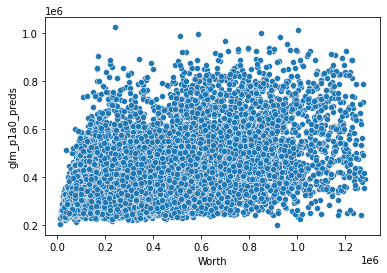

In [56]:
sns.scatterplot(y_train.Worth, y_train.glm_p1a0_preds)

* *After MVP*: Add features, use k-best or RFE to determine which features to include
* *After MVP*: Loop model-performance using new feature set and suitable names
* *After MVP*: "Choose" best-performing model
* **Present**: 
    * model-performance function
    * baseline performance
    * MVP model performance
    * After-MVP model performance
    * model selected

# #6. Revisit Step #3, #4, and #5 with more features than the MVP restriction

* Complete these steps:
    * Run at least 1 t-test and 1 correlation test (but as many as you need!)
    * Visualize all combinations of variables in some way(s).
    * What independent variables are correlated with the dependent?
    * Which independent variables are correlated with other independent variables?
* Run all *After MVP* steps

In [57]:
df = acquire.acquire_zillow()
df.head(3)

,ID,LocalityCode,DateSold,Worth,Taxes,Rooms,Baths,Beds,GarageCarCount,Stories,LotSize,GarageSize,FinishedSize,YearBuilt,County,Zipcode,UseCode
0,11721753,6037.0,2017-07-21,205123.0,2627.48,0.0,2.0,3.0,NaN,NaN,5672.0,NaN,1316.0,1923.0,3101.0,95997.0,0100
1,11289917,6037.0,2017-06-23,136104.0,2319.90,0.0,2.0,3.0,NaN,NaN,8284.0,NaN,1458.0,1970.0,3101.0,97318.0,0101
2,11705026,6037.0,2017-06-30,35606.0,543.69,0.0,1.0,2.0,NaN,NaN,6707.0,NaN,1421.0,1911.0,3101.0,96018.0,0100


In [58]:
print('Number of records:', len(df), '\n')
print('Number of nulls:\n', df.isna().mean())

Number of records: 28124 

Number of nulls:
 ID                0.000000
LocalityCode      0.000000
DateSold          0.000000
Worth             0.000036
Taxes             0.000036
Rooms             0.000000
Baths             0.000000
Beds              0.000000
GarageCarCount    0.646103
Stories           0.715474
LotSize           0.007218
GarageSize        0.646103
FinishedSize      0.001671
YearBuilt         0.002525
County            0.000000
Zipcode           0.000604
UseCode           0.000000
dtype: float64


High-Nullcount Columns (drop): 
- GarageCarCount (65%)
- GarageSize (65%)
- Stories (72%)

Odd columns (drop):
- Zipcode (values vary wildly from FIPS code [aliased as LocalityCode])
- County (redundant to FIPS code)
- UseCode 
    * Lots of unknown codes, but the codes I found showed 'Single Residence' and various amendments to it such as 'with pool'. Maybe some insights here, like if a place having a pool is worth more than one without a pool, but the codes aren't trustworthy enough to make a yes/no judgment call on 'has-pool' due to gaps in code definition.
- Rooms (20,000 results have zero rooms... no thanks)

Has nulls (fix):
- Worth
- Taxes
- LotSize
- FinishedSize
- YearBuilt

In [59]:
df = df.drop(columns=['GarageCarCount',
                      'GarageSize',
                      'Stories',
                      'Zipcode',
                      'County',
                      'UseCode',
                      'Rooms'])

In [60]:
print(df.shape)
print(df.dropna().shape)

(28124, 10)
(27851, 10)


It's safe to drop all nulls.

In [61]:
df = df.dropna()
df.head(10)

,ID,LocalityCode,DateSold,Worth,Taxes,Baths,Beds,LotSize,FinishedSize,YearBuilt
0,11721753,6037.0,2017-07-21,205123.0,2627.48,2.0,3.0,5672.0,1316.0,1923.0
1,11289917,6037.0,2017-06-23,136104.0,2319.90,2.0,3.0,8284.0,1458.0,1970.0
2,11705026,6037.0,2017-06-30,35606.0,543.69,1.0,2.0,6707.0,1421.0,1911.0
3,14269464,6059.0,2017-06-01,880456.0,9819.72,3.0,4.0,4975.0,2541.0,2003.0
4,11446756,6037.0,2017-08-23,107110.0,1399.27,2.0,3.0,5000.0,1491.0,1955.0
5,11389003,6037.0,2017-06-01,614000.0,7673.19,2.0,3.0,7300.0,1650.0,1949.0
6,11967869,6037.0,2017-06-29,274237.0,3267.47,1.0,2.0,2908.0,693.0,1921.0
7,11429175,6037.0,2017-08-23,164269.0,2169.62,2.0,4.0,5599.0,1655.0,1955.0
9,11921077,6037.0,2017-07-18,224906.0,4086.17,2.0,3.0,6246.0,1331.0,1954.0
10,11391972,6037.0,2017-07-20,286062.0,6093.88,2.0,3.0,4038.0,1440.0,1938.0


In [62]:
# df[df.LocalityCode == 6037].UseCode.unique()

In [63]:
# df[df.LocalityCode == 6059].UseCode.unique()

In [64]:
# df[df.LocalityCode == 6111].UseCode.unique()

In [65]:
# df[df.LocalityCode == 6037].count()

- 6037: Los Angeles, CA
    * 0100-series codes are all 'Single Residence' with additional attributes (0101, 0102, ..., 0130, ...)
    * https://dts.edatatrace.com/dts3/content/doc/whelp/mergedProjects/dts2tt/mergedProjects/dts2ttcs/land_use_la.htm
- 6059: Orange, CA
    * unknown codes
- 6111: Ventura, CA
    * unknown codes

https://portal.assessor.lacounty.gov/parceldetail/4115015003
* Use Code: 0100 (Single Family Residence)
* 0 = Residential
* 1 = Single Family Residence
* 0 = Unused or Unknown Code (No Meaning)
    * 1 = High Value Residence, X Cost Classification
* 0 = Unused or Unknown Code (No Meaning)
    * 1 = Pool
    * 3 = Pool and Misc
- SUBSET 0100
- Design Type: 0110
- 0 = Residential
- 1 = Single Family Residence
- 1 = Floor or Wall Heat
    * 2: Central Heat
    * 3: Central Refrigeration and Heat
- 0 = Unused or Unknown Code (No Meaning)
    * 1: Pool
    * 2: Misc
        * I think this may mean coastal residence? *No*, check APN 7564-023-013
        * 7564-023-012 - Pool+Misc
        * 7564-025-016 - Pool+Misc
        * Might be +detached building, +outdoor kitchen, +basketball court (or other entertainment area), etc
            * Not solar, see APN 7564-026-016
        * Might be Pool *and* Therapy Pool?? *No*, why just 'Misc' then?
            * 7564-026-004 Has Pool and Misc... in image, has pool and spa...
            * 7564-026-005 Has Pool, no Misc... in image, has pool, no spa...
                * 7564-026-006 fits
    * 3. Pool and Misc
    * 4: Therapy Pool (Spa)

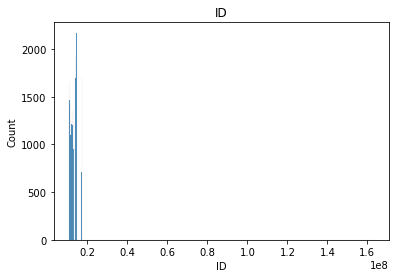

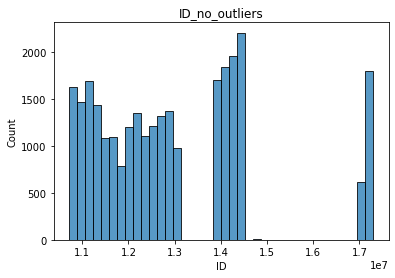

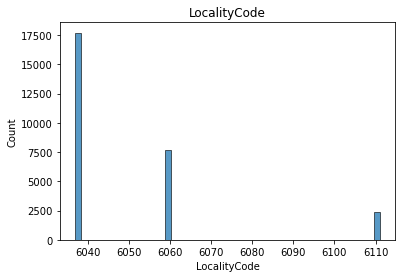

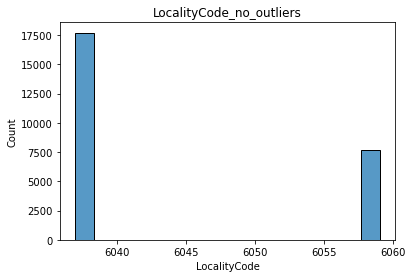

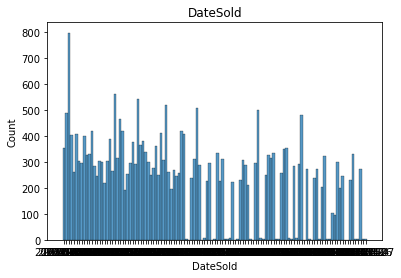

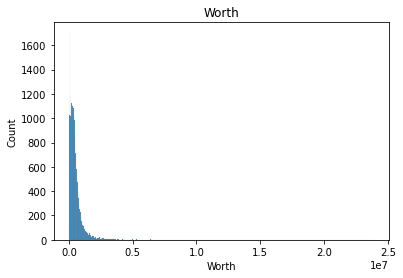

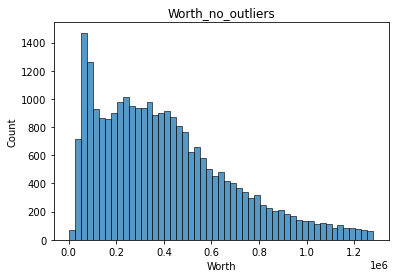

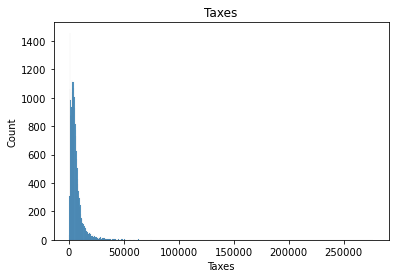

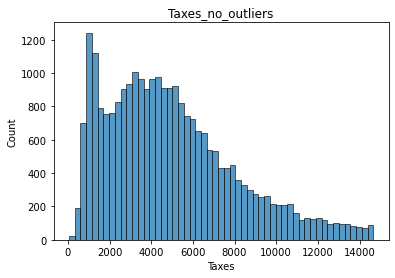

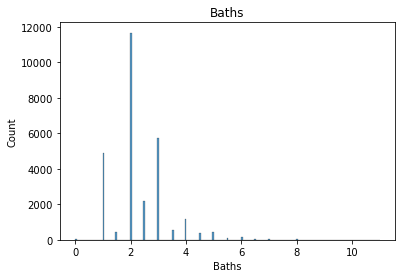

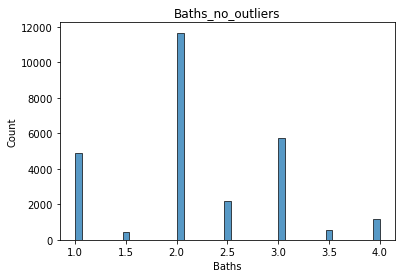

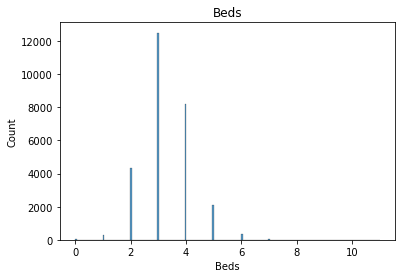

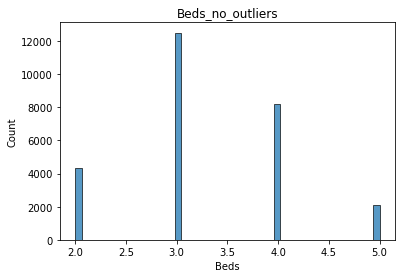

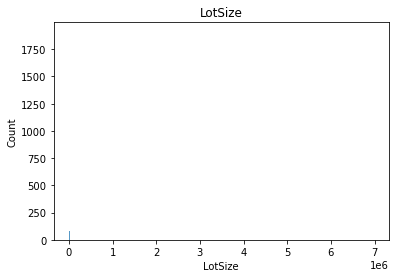

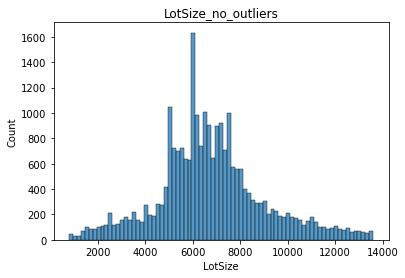

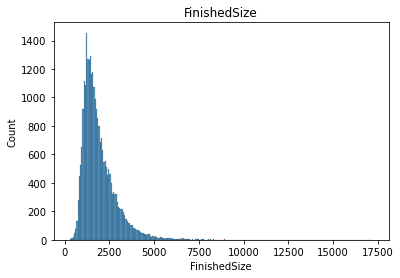

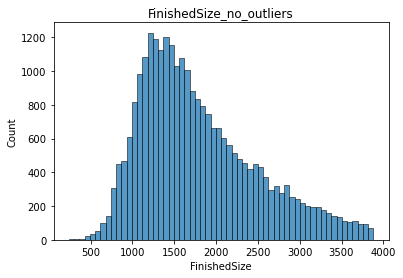

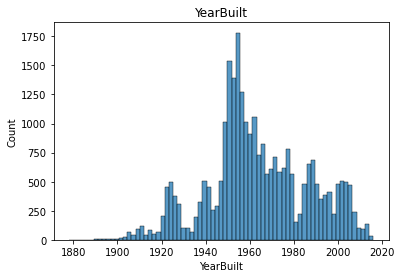

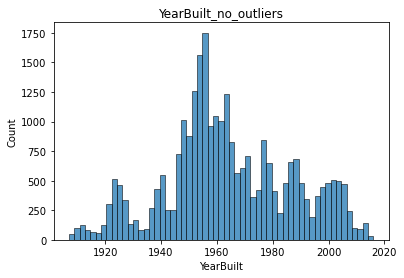

In [66]:
prep.initial_plots(df)

Univariate takeaways:
- Noticed 'Rooms' had 20,000 values of zero... so went back above and dropped column.
- Make sure not to run IQR on LocalityCode and other similar columns...

Additional hypothesis:
- The value of homes in Orange County is higher than the value of homes in all three counties combined

In [67]:
alpha = .05
t, p = stats.mannwhitneyu(df[df.LocalityCode == 6059].Worth, df.Worth)
significant(alpha=alpha, truth=(t > 0), p=p)

Reject the null hypothesis


Preparation for modeling with new features

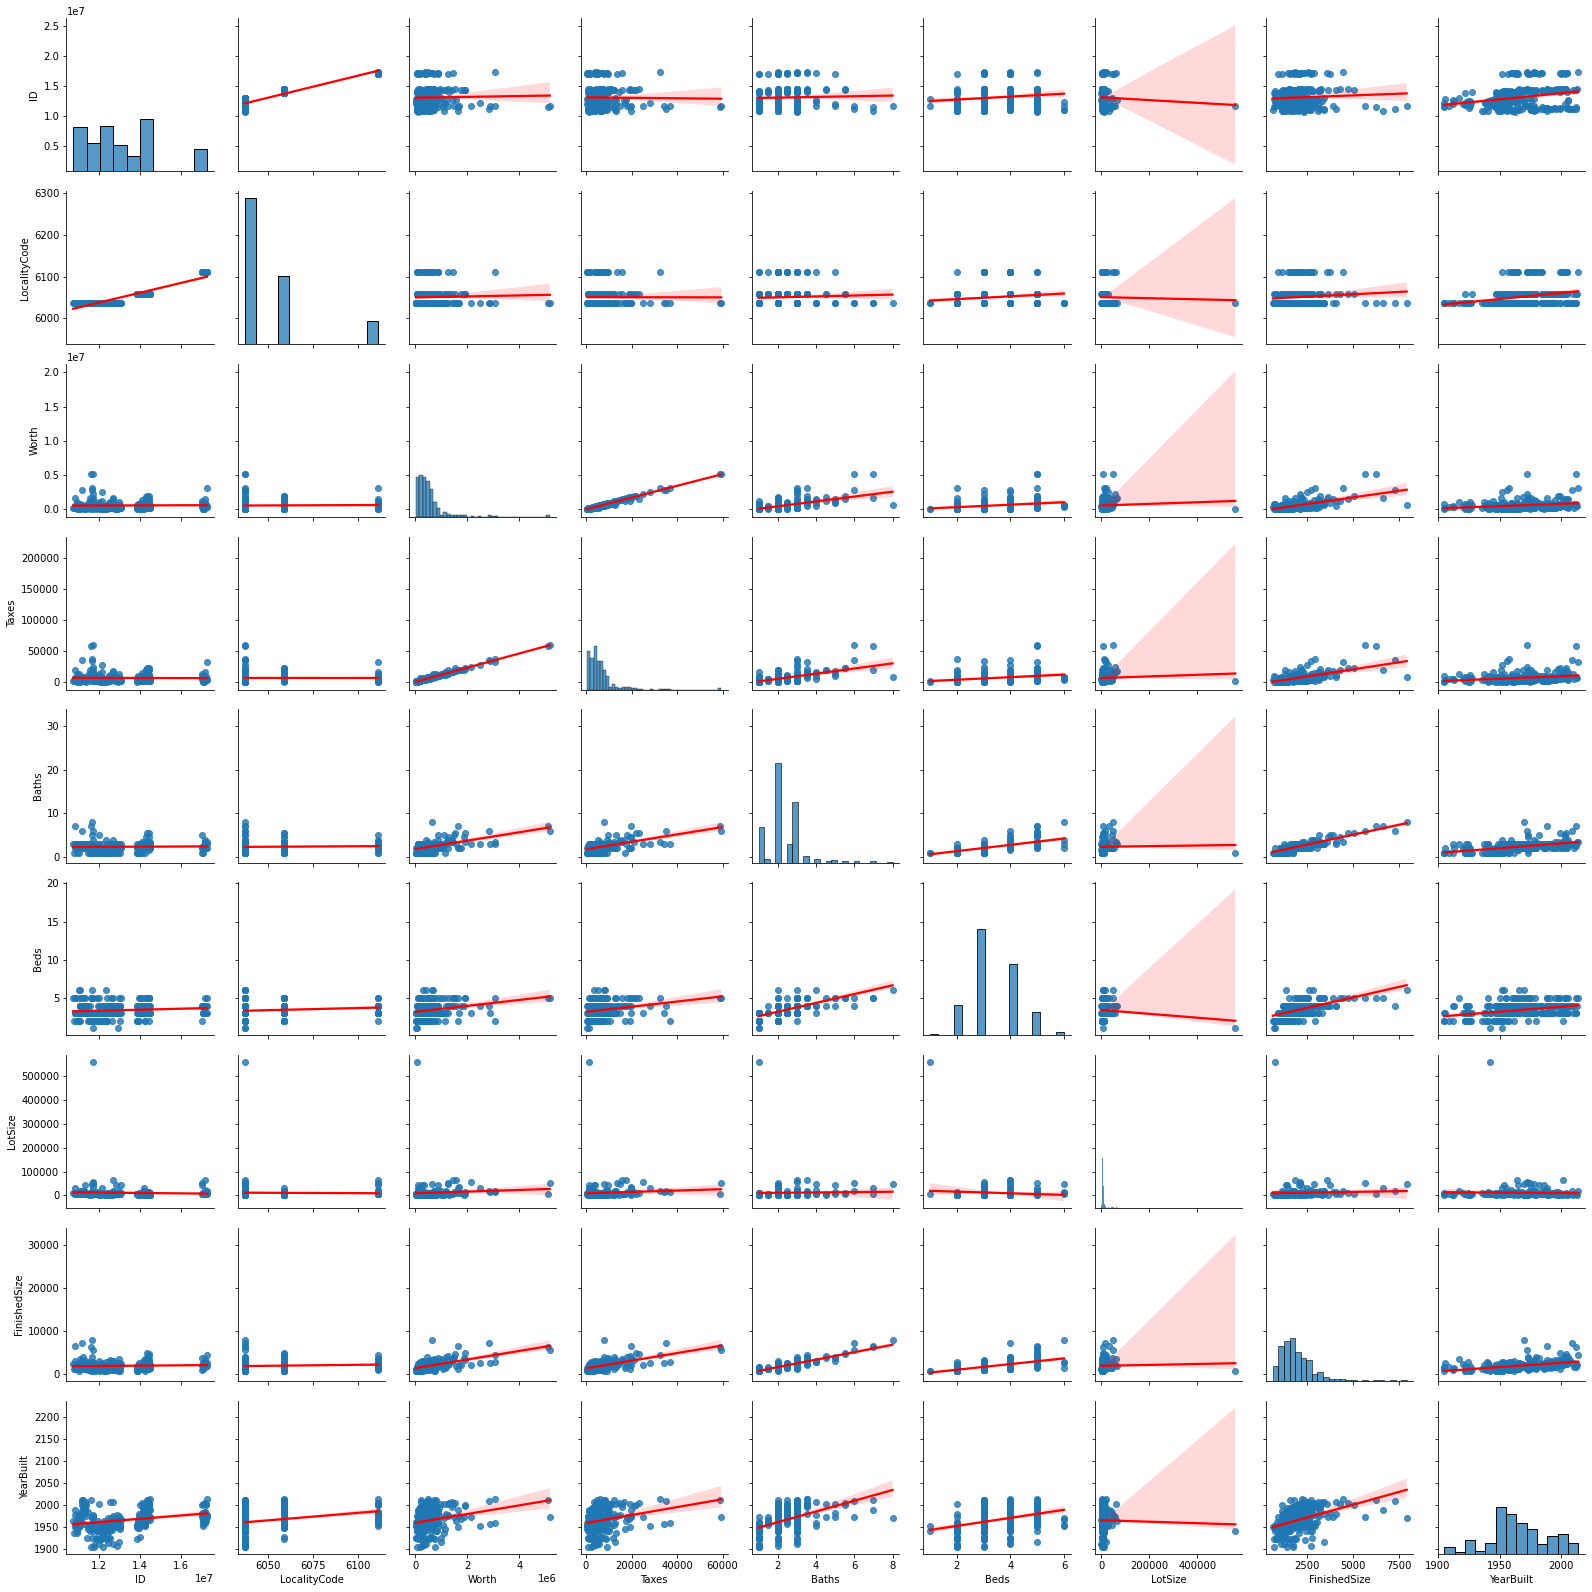

In [68]:
sns.pairplot(df.sample(300, random_state=123), kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [69]:
df.columns

Index(['ID', 'LocalityCode', 'DateSold', 'Worth', 'Taxes', 'Baths', 'Beds',
       'LotSize', 'FinishedSize', 'YearBuilt'],
      dtype='object')

In [70]:
df['ID'] = df['ID'].astype('O')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27851 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            27851 non-null  object 
 1   LocalityCode  27851 non-null  float64
 2   DateSold      27851 non-null  object 
 3   Worth         27851 non-null  float64
 4   Taxes         27851 non-null  float64
 5   Baths         27851 non-null  float64
 6   Beds          27851 non-null  float64
 7   LotSize       27851 non-null  float64
 8   FinishedSize  27851 non-null  float64
 9   YearBuilt     27851 non-null  float64
dtypes: float64(8), object(2)
memory usage: 3.3+ MB


In [71]:
df['YearBuilt'].sort_values(ascending=False)

18699    2016.0
12936    2015.0
2460     2015.0
25874    2015.0
16700    2015.0
          ...  
5973     1887.0
9867     1885.0
17640    1882.0
20065    1880.0
6464     1878.0
Name: YearBuilt, Length: 27851, dtype: float64

In [72]:
df['Age'] = 2017 - df['YearBuilt']
df.head(3)

,ID,LocalityCode,DateSold,Worth,Taxes,Baths,Beds,LotSize,FinishedSize,YearBuilt,Age
0,11721753,6037.0,2017-07-21,205123.0,2627.48,2.0,3.0,5672.0,1316.0,1923.0,94.0
1,11289917,6037.0,2017-06-23,136104.0,2319.90,2.0,3.0,8284.0,1458.0,1970.0,47.0
2,11705026,6037.0,2017-06-30,35606.0,543.69,1.0,2.0,6707.0,1421.0,1911.0,106.0


Hypothesis:
- The values of Age before the interquartile rule is applied is statistically significantly different from the values of Age after the interquartile rule.

In [73]:
alpha = .05 / 2
k = 1.5
col_list = ['Age']
df_test = prep.remove_outliers(df=df, k=k, col_list=col_list)
t, p = stats.mannwhitneyu(df.Age, df_test.Age)
print(t, p)
significant(alpha=alpha, truth=(t != 0), p=p)

384060612.5 0.15938271762778045
Accept the null hypothesis


**The values of Age before the interquartile rule is applied is *not* statistically significantly different from the values of Age after the interquartile rule.**
- I am dropping the YearBuilt column in favor of Age. I am also dropping outliers for Age.

In [74]:
col_list = ['Worth', 'Taxes', 'Baths', 'Beds', 'LotSize',
       'FinishedSize', 'Age']
df_test = prep.remove_outliers(df=df, k=k, col_list=col_list)
df_test.head(3)

,ID,LocalityCode,DateSold,Worth,Taxes,Baths,Beds,LotSize,FinishedSize,YearBuilt,Age
0,11721753,6037.0,2017-07-21,205123.0,2627.48,2.0,3.0,5672.0,1316.0,1923.0,94.0
1,11289917,6037.0,2017-06-23,136104.0,2319.90,2.0,3.0,8284.0,1458.0,1970.0,47.0
3,14269464,6059.0,2017-06-01,880456.0,9819.72,3.0,4.0,4975.0,2541.0,2003.0,14.0


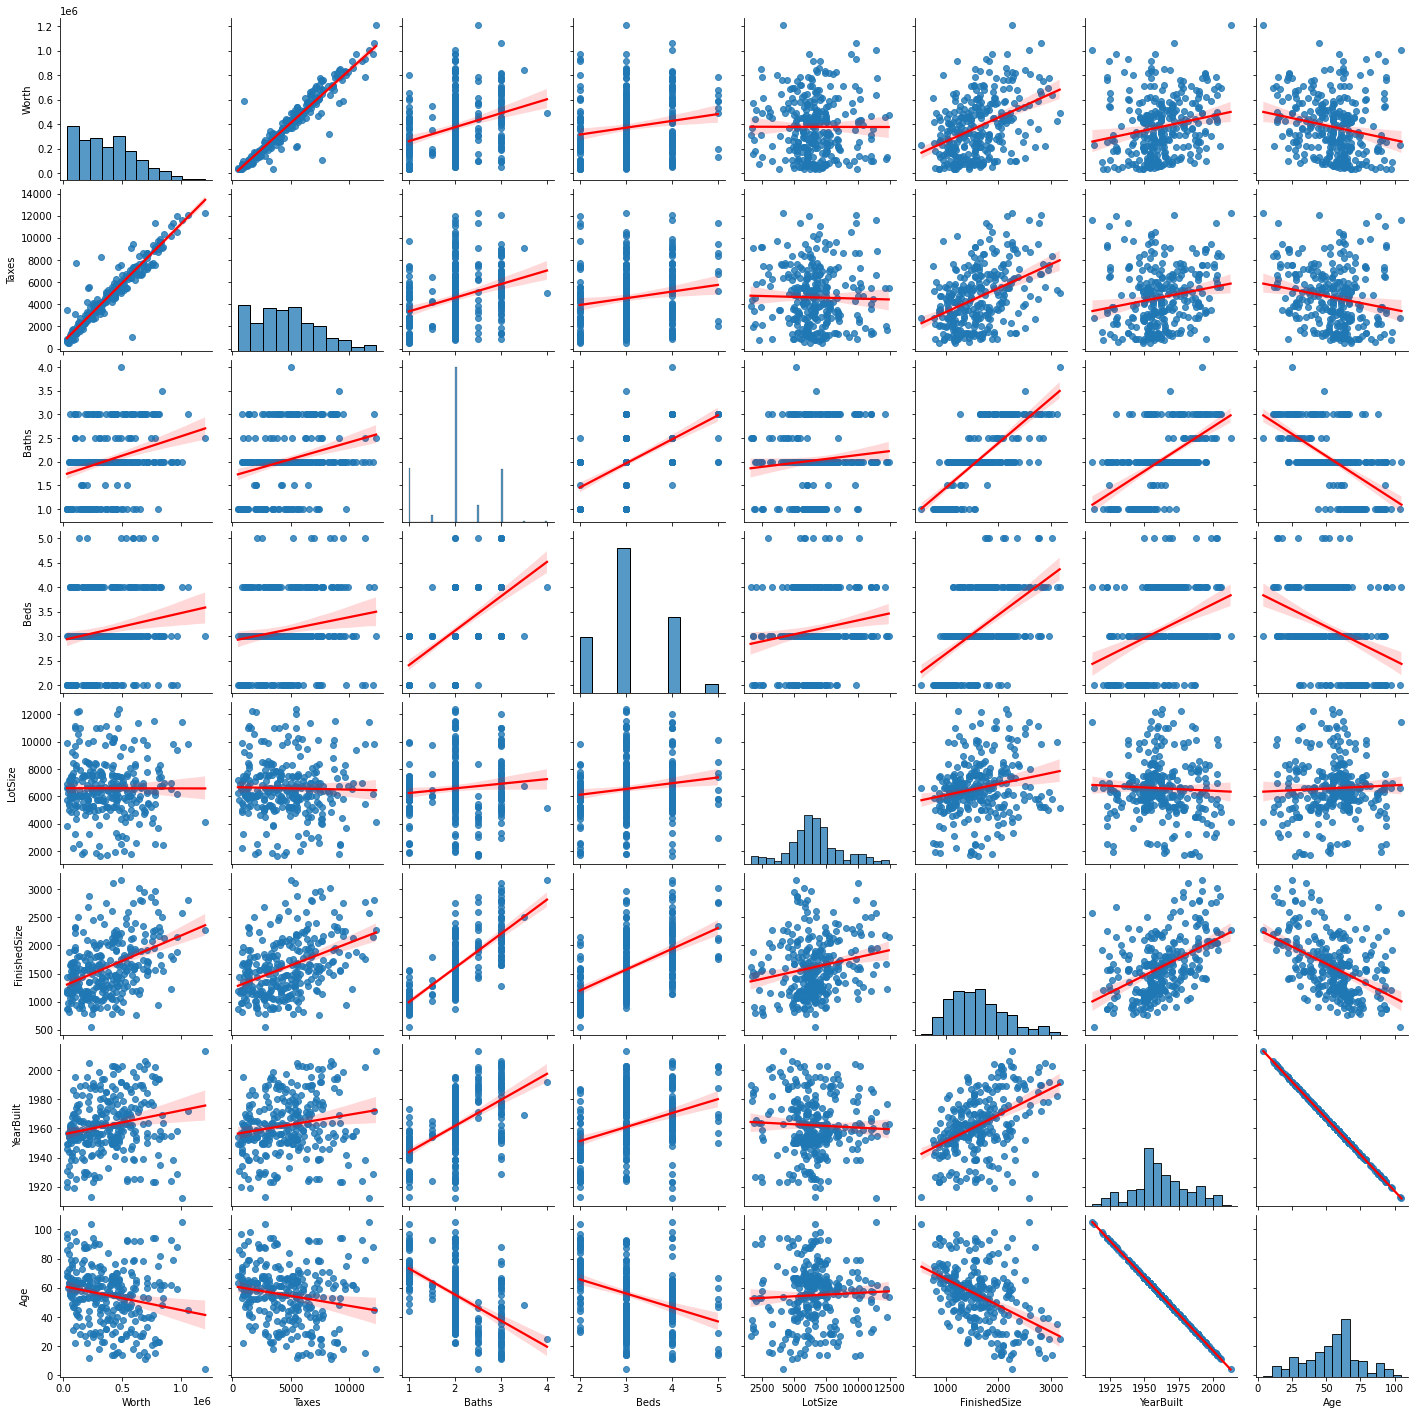

In [75]:
sns.pairplot(df_test.drop(columns=['ID','DateSold','LocalityCode']).sample(300, random_state=123), kind="reg", plot_kws={'line_kws':{'color':'red'}})

I like these features! I'm going to keep all but one of them, selecting using RFE. That's after train-test split and scaling, though.

In [76]:
# Pushing function to prep.py
def clean_data(df):
    df['ID'] = df['ID'].astype('O')
    df['Age'] = 2017 - df['YearBuilt']
    df['LocalityCode'] = df['LocalityCode'].astype('int').astype('str')
    cols = ['ID', 'LocalityCode', 'DateSold', 'Worth', 'Taxes', 'Baths', 'Beds', 'LotSize',
            'FinishedSize', 'Age']
    df = df[cols]
    df = df.dropna().drop_duplicates()
    df = prep.remove_outliers(df, k=1.5, col_list=cols[3:])
    return df

In [78]:
df = acquire.acquire_zillow()
df = clean_data(df)
X_train, y_train, X_validate, y_validate, X_test, y_test = prep.split_isolate_data(df)
X_train_exp, X_train, X_validate, X_test = prep.scale_data(X_train, X_validate, X_test)
X_train_exp.head(10)

ValueError: could not convert string to float: '2017-08-08'

# #7. Push work and findings to a slide deck
- Practice/script the presentation
- Present!

# Notes to self
- "You will want to make sure you are using the best fields to represent square feet of home, number of bedrooms, and number of bathrooms. "Best" meaning the most accurate and available information. Here you will need to do some data investigation in the database and use your domain expertise to make some judgement calls."
- "Brainstorming ideas and form hypotheses related to how variables might impact or relate to each other, both within independent variables and between the independent variables and dependent variable."
- "Document any ideas for new features you may have while first looking at the existing variables and the project goals ahead of you."
- "Add a data dictionary in your notebook at this point that defines all the fields used in your model and your analysis and answers the question, "Why did you use the fields you used?". e.g. "Why did you use bedroom_field1 over bedroom_field2?", not, "Why did you use number of bedrooms?""